In [1]:
# import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import scipy.stats as stats

In [2]:
df_orig = pd.read_csv('MotoGP_2002_2018.csv', index_col=0, parse_dates=['Date'])

In [3]:
df_orig.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 24141 entries, 0 to 24140
Data columns (total 29 columns):
Year                          24141 non-null int64
TRK                           24141 non-null object
Track                         24141 non-null object
Category                      24141 non-null object
Session                       24141 non-null object
Date                          24136 non-null datetime64[ns]
Track_Condition               20883 non-null object
Track_Temp                    20883 non-null float64
Air_Temp                      20883 non-null float64
Humidity                      20883 non-null float64
Position                      24136 non-null object
Points                        24136 non-null float64
Rider_Number                  20883 non-null float64
Rider_Name                    24136 non-null object
Nationality                   24136 non-null object
Team_Name                     20883 non-null object
Bike                          24136 non-null ob

In [4]:
df = df_orig.copy(deep=True)


In [5]:
# convert finish time into a numerical since it'll be the target of our regression
df['Finish_Time'] = df['Finish_Time'].map(lambda x: pd.to_timedelta(x))
df['Finish_Time_ms'] = df['Finish_Time'].map(lambda x: x/pd.to_timedelta(1, unit='ms'))

# add up left and right corners
df['corners'] = df['Left_Corners'] + df['Right_Corners']

# drop N/A values
df.dropna(axis = 0, inplace=True)

In [6]:

# examine the top 20 riders
(df
 .groupby(['Rider_Name'])['Points']
 .mean().reset_index()
 .sort_values(by='Points', ascending=False)
).head(20)

,Rider_Name,Points
66,Can ONCU,25.000000
86,Daniel PEDROSA,22.555556
282,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
206,Jorge LORENZO,17.375000
439,Valentino ROSSI,16.077419
82,Dani PEDROSA,15.985507
300,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
191,Joan MIR,13.472222


In [7]:

df.replace(to_replace='Daniel PEDROSA', value='Dani PEDROSA', inplace=True)
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
66,Can ONCU,25.000000
281,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
205,Jorge LORENZO,17.375000
82,Dani PEDROSA,16.387755
438,Valentino ROSSI,16.077419
299,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
190,Joan MIR,13.472222
33,Andrea DOVIZIOSO,13.006623


In [8]:

df.groupby('Rider_Name').count()

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
Rider_Name,,,,,,,,,,,,,,,,,,,,,
Aaron POLANCO,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Adam NORRODIN,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27
Adrian MARTIN,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
Ai OGURA,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Aitor RODRIGUEZ,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
Alan TECHER,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
Albert ARENAS,20,20,20,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,20
Alberto MONCAYO,43,43,43,43,43,43,43,43,43,43,...,43,43,43,43,43,43,43,43,43,43
Aleix ESPARGARO,124,124,124,124,124,124,124,124,124,124,...,124,124,124,124,124,124,124,124,124,124


In [9]:
threshold = 2000000
df[(df.Finish_Time_ms <= threshold)].sample(5)

,Year,TRK,Track,Category,Session,Date,Track_Condition,Track_Temp,Air_Temp,Humidity,...,Left_Corners,Right_Corners,track_width,length of longest straight,MotoGP_avg_speed,GP_distance,Moto2_distance,Moto3_distance,Finish_Time_ms,corners
2834,2017,JPN,JPN - Twin Ring Motegi,Moto2,RAC,2017-10-15,Wet,15.0,14.0,97.0,...,6.0,8.0,15.0,762.0,162.2,115.2,105.6,96.0,1969835.0,14.0
5914,2015,ARA,ARA - MotorLand Aragón,Moto2,RAC,2015-09-27,Dry,34.0,21.0,57.0,...,10.0,7.0,15.0,968.0,167.0,116.8,106.6,96.5,1607509.0,17.0
10590,2012,RSM,RSM - Misano World Circuit Marco Simoncelli,Moto2,RAC2,2012-09-16,Dry,30.0,22.0,61.0,...,6.0,10.0,14.0,530.0,162.6,114.1,105.7,97.2,1402787.0,16.0
20342,2005,GER,GER - Sachsenring,125cc,RAC,2005-07-31,Dry,26.0,20.0,27.0,...,10.0,3.0,12.0,700.0,160.6,110.1,102.8,99.1,1835162.0,13.0
8131,2013,AME,AME - Circuit Of The Americas,Moto3,RAC,2013-04-21,Dry,27.0,19.0,62.0,...,11.0,9.0,15.0,1200.0,158.4,110.3,99.2,93.7,1417442.0,20.0


In [10]:
df_c = df.drop(axis=1, columns=['TRK', 'Track', 'Session', 'Date', 'Position', 'Rider_Name',
                                'Rider_Number', 'Nationality', 'Team_Name', 'Time', 'Finish_Time',
                                'Category', 'Left_Corners', 'Right_Corners', 'Avg_Speed'])

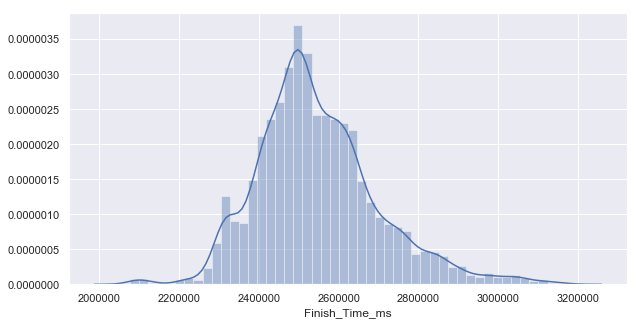

In [11]:
df_c_normal = df_c[df_c.Finish_Time_ms >= threshold]
plt.figure(figsize=(10,5))
sns.distplot(df_c_normal.Finish_Time_ms);

In [12]:
# df = df[df.Category == "MotoGP"]
# df

In [13]:
df_rider_mean = (df
                 .groupby(['Rider_Name'])['Points']
                 .mean().reset_index()
                 .sort_values(by='Points', ascending=False)
                )
df_rider_mean.rename(columns={'Points':'points_mean'}, inplace=True)
df_rider_mean.head(20)

,Rider_Name,points_mean
66,Can ONCU,25.000000
281,Marc MARQUEZ,19.358974
69,Casey STONER,17.742857
205,Jorge LORENZO,17.375000
82,Dani PEDROSA,16.387755
438,Valentino ROSSI,16.077419
299,Maverick VIÑALES,13.833333
23,Alex RINS,13.500000
190,Joan MIR,13.472222
33,Andrea DOVIZIOSO,13.006623


In [15]:
# vc = df_rider_mean['Rider_Name'].value_counts()
# # u  = [i not in set(vc[vc==1].index) for i in df_rider_mean['Rider_Name']]
# # df = df[u]
# vc


In [16]:
df_merged = df.merge(df_rider_mean)
df_model_prepped = df_merged[["Bike","length of longest straight","Right_Corners","Left_Corners", "Year", "track_width", "MotoGP_avg_speed", "GP_distance", "corners","Rider_Name","points_mean", "Finish_Time_ms", "Track_Condition", "Track_Temp", "Humidity", "Position", "Track","Trk Length","Moto3_distance", "Moto2_distance"]]
df_model_prepped["Rider_Name"] = df_model_prepped["Rider_Name"].apply(lambda x: x.lower())
df_model_prepped["Bike"] = df_model_prepped["Bike"].apply(lambda x: x.lower())
df_model_prepped["Track_Condition"] = df_model_prepped["Track_Condition"].apply(lambda x: x.lower())
df_model_prepped["Track"] = df_model_prepped["Track"].apply(lambda x: x.lower())
df_model_prepped.to_csv("model_prepped_data.csv")

C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\Rconw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a co

In [17]:
df_merged_encoded = df_model_prepped.copy()
df_merged_encoded.head()

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Finish_Time_ms,Track_Condition,Track_Temp,Humidity,Position,Track,Trk Length,Moto3_distance,Moto2_distance
0,ducati,1068.0,10.0,6.0,2018,12.0,166.6,118.4,16.0,andrea dovizioso,13.006623,2554654.0,dry,23.0,46.0,1,qat - losail international circuit,5.4,96.8,107.6
1,ducati,1076.0,9.0,5.0,2018,16.0,172.7,120.2,14.0,andrea dovizioso,13.006623,2458875.0,wet,23.0,94.0,6,arg - termas de río hondo,4.8,100.9,110.5
2,ducati,1200.0,9.0,11.0,2018,15.0,158.4,110.3,20.0,andrea dovizioso,13.006623,2525572.0,dry,35.0,45.0,5,ame - circuit of the americas,5.5,93.7,99.2
3,ducati,487.0,12.0,6.0,2018,14.0,173.1,118.1,18.0,andrea dovizioso,13.006623,2476285.0,dry,40.0,32.0,4,ned - tt circuit assen,4.5,99.9,109.0
4,ducati,700.0,3.0,10.0,2018,12.0,160.6,110.1,13.0,andrea dovizioso,13.006623,2472960.0,dry,48.0,48.0,7,ger - sachsenring,3.7,99.1,102.8


In [18]:


from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
lb_make = LabelEncoder()
lb_make1 = LabelEncoder()
lb_make2 = LabelEncoder()
lb_make3 = LabelEncoder()


df_merged_encoded['Track_Condition'] = lb_make.fit_transform(df_model_prepped['Track_Condition'])
df_merged_encoded['Track'] = lb_make1.fit_transform(df_model_prepped['Track'])
df_merged_encoded['Rider_Name'] = lb_make2.fit_transform(df_model_prepped['Rider_Name'])
df_merged_encoded['Bike'] = lb_make3.fit_transform(df_model_prepped['Bike'])
df_merged_encoded.head()

     

,Bike,length of longest straight,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,Rider_Name,points_mean,Finish_Time_ms,Track_Condition,Track_Temp,Humidity,Position,Track,Trk Length,Moto3_distance,Moto2_distance
0,12,1068.0,10.0,6.0,2018,12.0,166.6,118.4,16.0,33,13.006623,2554654.0,0,23.0,46.0,1,10,5.4,96.8,107.6
1,12,1076.0,9.0,5.0,2018,16.0,172.7,120.2,14.0,33,13.006623,2458875.0,1,23.0,94.0,6,2,4.8,100.9,110.5
2,12,1200.0,9.0,11.0,2018,15.0,158.4,110.3,20.0,33,13.006623,2525572.0,0,35.0,45.0,5,0,5.5,93.7,99.2
3,12,487.0,12.0,6.0,2018,14.0,173.1,118.1,18.0,33,13.006623,2476285.0,0,40.0,32.0,4,9,4.5,99.9,109.0
4,12,700.0,3.0,10.0,2018,12.0,160.6,110.1,13.0,33,13.006623,2472960.0,0,48.0,48.0,7,6,3.7,99.1,102.8


In [19]:
df_merged_encoded.columns

Index(['Bike', 'length of longest straight', 'Right_Corners', 'Left_Corners',
       'Year', 'track_width', 'MotoGP_avg_speed', 'GP_distance', 'corners',
       'Rider_Name', 'points_mean', 'Finish_Time_ms', 'Track_Condition',
       'Track_Temp', 'Humidity', 'Position', 'Track', 'Trk Length',
       'Moto3_distance', 'Moto2_distance'],
      dtype='object')

In [21]:
df_merged_encoded = df_merged_encoded[["Rider_Name","length of longest straight","Bike",
                                       "Right_Corners","Left_Corners", "Year", "track_width","MotoGP_avg_speed", 
                                       "GP_distance", "corners","points_mean",  "Track_Condition", "Track_Temp", 
                                       "Humidity", "Track","Position", "Trk Length","Moto3_distance", "Moto2_distance"]]

# 'Year', 'Track_Temp', 'Air_Temp', 'Humidity', 'Points',
#        'track_length_km', 'width_m', 'straight_m', 'GP_avg_speed', 'gp_dist',
#        'm2_dist', 'm3_dist', 'Finish_Time_ms', 'corners', 'points_mean',
#        'Category_125cc', 'Category_250cc', 'Category_Moto2', 'Category_Moto3',
#        'Category_MotoGP', 'Track_Condition_Dry', 'Track_Condition_Wet',
#        'Track_Condition_Wet-Dry'

df_merged_encoded.head()


,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,track_width,MotoGP_avg_speed,GP_distance,corners,points_mean,Track_Condition,Track_Temp,Humidity,Track,Position,Trk Length,Moto3_distance,Moto2_distance
0,33,1068.0,12,10.0,6.0,2018,12.0,166.6,118.4,16.0,13.006623,0,23.0,46.0,10,1,5.4,96.8,107.6
1,33,1076.0,12,9.0,5.0,2018,16.0,172.7,120.2,14.0,13.006623,1,23.0,94.0,2,6,4.8,100.9,110.5
2,33,1200.0,12,9.0,11.0,2018,15.0,158.4,110.3,20.0,13.006623,0,35.0,45.0,0,5,5.5,93.7,99.2
3,33,487.0,12,12.0,6.0,2018,14.0,173.1,118.1,18.0,13.006623,0,40.0,32.0,9,4,4.5,99.9,109.0
4,33,700.0,12,3.0,10.0,2018,12.0,160.6,110.1,13.0,13.006623,0,48.0,48.0,6,7,3.7,99.1,102.8


In [22]:
df_merged_encoded = df_merged_encoded[~df_merged_encoded.Position.str.contains("crash")]
df_merged_encoded["Position"] = df_merged_encoded["Position"].astype(int)

In [23]:
df_merged_encoded.dtypes

Rider_Name                      int32
length of longest straight    float64
Bike                            int32
Right_Corners                 float64
Left_Corners                  float64
Year                            int64
track_width                   float64
MotoGP_avg_speed              float64
GP_distance                   float64
corners                       float64
points_mean                   float64
Track_Condition                 int32
Track_Temp                    float64
Humidity                      float64
Track                           int32
Position                        int32
Trk Length                    float64
Moto3_distance                float64
Moto2_distance                float64
dtype: object

In [39]:

import operator

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

x = df_merged_encoded.drop("Position", axis = 1)
y = df_merged_encoded["Position"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

#String Encoding 
# for i in x_train.columns:
#     if x_train[i].dtype=='object' or x_test[i].dtype=='object':
#         lbl = preprocessing.LabelEncoder()
#         lbl.fit(list(x_train[i].values) + list(x_test[i].values))
#         x_train[i] = lbl.transform(list(x_train[i].values))
#         x_test[i] = lbl.transform(list(x_test[i].values))

polynomial_features= PolynomialFeatures(degree=3)
x_poly = polynomial_features.fit_transform(x_train)


model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)

rmse = np.sqrt(mean_squared_error(y_train,y_poly_pred))
r2 = r2_score(y_train,y_poly_pred)
print(rmse)
print(r2)


4.954768429695489
0.5438026647084191


In [25]:

x_poly_test = polynomial_features.fit_transform(x_test)
y_poly_pred = model.predict(x_poly_test)

rmse = np.sqrt(mean_squared_error(y_test,y_poly_pred))
r2 = r2_score(y_test,y_poly_pred)
print(rmse)
print(r2)


5.296438299991612
0.5087342833709403


In [ ]:
# df_merged_encoded['Track_Condition'] = lb_make.inverse_transform(df_merged_encoded['Track_Condition'])
# df_merged_encoded['Track'] = lb_make1.inverse_transform(df_merged_encoded['Track'])
# df_merged_encoded['Rider_Name'] = lb_make2.inverse_transform(df_merged_encoded['Rider_Name'])
# df_merged_encoded['Bike'] = lb_make3.inverse_transform(df_merged_encoded['Bike'])

# df_model_prepped.head()

In [ ]:
df15 = pd.DataFrame({'Actual': y_test, 'Predicted': y_poly_pred})
df15['Rider_Name']= df_merged_encoded['Rider_Name']

df15


In [26]:
df_Test = pd.read_csv('Test_csv.csv')

In [27]:
df_Test

,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,Track_Width,Moto_GP_avg_spd,GP_Distance,Corners,Track_Condition,Track_Temp,Humidity,Track
0,Andrea DOVIZIOSO,1068,Ducati,10,6,2019,12,166.6,118.4,16,dry,19,52,qat - losail international circuit


In [28]:
df_Test["rider_mean"] = 12.598361

In [29]:
#df_Test = df_Test.merge(df_rider_mean)
df_Test.head()

,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,Track_Width,Moto_GP_avg_spd,GP_Distance,Corners,Track_Condition,Track_Temp,Humidity,Track,rider_mean
0,Andrea DOVIZIOSO,1068,Ducati,10,6,2019,12,166.6,118.4,16,dry,19,52,qat - losail international circuit,12.598361


In [30]:

df_Test["Rider_Name"] = df_Test["Rider_Name"].apply(lambda x: x.lower())
df_Test["Bike"] = df_Test["Bike"].apply(lambda x: x.lower())
df_Test["Track_Condition"] = df_Test["Track_Condition"].apply(lambda x: x.lower())
df_Test["Track"] = df_Test["Track"].apply(lambda x: x.lower())


In [31]:
df_Test['Track_Condition'] = lb_make.transform(df_Test['Track_Condition'])
df_Test['Track'] = lb_make1.transform(df_Test['Track'])
df_Test['Rider_Name'] = lb_make2.transform(df_Test['Rider_Name'])
df_Test['Bike'] = lb_make3.transform(df_Test['Bike'])
df_Test

,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,Track_Width,Moto_GP_avg_spd,GP_Distance,Corners,Track_Condition,Track_Temp,Humidity,Track,rider_mean
0,33,1068,12,10,6,2019,12,166.6,118.4,16,0,19,52,10,12.598361


In [32]:
df_Test['Position'] = df_Test.apply(lambda _: '', axis=1)
df_Test

,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,Track_Width,Moto_GP_avg_spd,GP_Distance,Corners,Track_Condition,Track_Temp,Humidity,Track,rider_mean,Position
0,33,1068,12,10,6,2019,12,166.6,118.4,16,0,19,52,10,12.598361,


In [33]:
cols = df_Test.columns.tolist()
#df_Test = df_Test[["Rider_Name","length of longest straight","Bike","Right_Corners","Left_Corners", "Year", "track_width","MotoGP_avg_speed", "GP_distance", "corners","points_mean",  "Track_Condition", "Track_Temp", "Humidity", "Track","Position"]]

In [34]:
cols = ["Rider_Name","length of longest straight","Bike","Right_Corners","Left_Corners","Year","Track_Width","Moto_GP_avg_spd","GP_Distance","Corners","rider_mean", "Track_Condition","Track_Temp","Humidity","Track","Position"]
df_Test = df_Test[cols]
df_Test

,Rider_Name,length of longest straight,Bike,Right_Corners,Left_Corners,Year,Track_Width,Moto_GP_avg_spd,GP_Distance,Corners,rider_mean,Track_Condition,Track_Temp,Humidity,Track,Position
0,33,1068,12,10,6,2019,12,166.6,118.4,16,12.598361,0,19,52,10,


In [40]:
x_TEST = df_Test.drop("Position", axis = 1)
x_poly_TEST = polynomial_features.fit_transform(x_TEST)
Y_TEST =df_Test["Position"]
model.predict(x_poly_TEST)

ValueError: shapes (1,816) and (1330,) not aligned: 816 (dim 1) != 1330 (dim 0)